In [78]:
import pandas as pd
import numpy as np
from pathlib import Path

## step 1 Load and clean and explore dataset 

In [79]:
def _to_float(x):
    if isinstance(x, str):
        x = x.strip().replace(",", ".")
    return pd.to_numeric(x, errors="coerce")

In [80]:
import pandas as pd
from pathlib import Path

FILES = ["NEPALISAT.xlsx", "RAAVANA.xlsx", "UGUISU.xlsx", "TSURU.xlsx"]

def inspect_one(path: Path):
    df = pd.read_excel(path, nrows=5, dtype=str)
    df = df.drop(columns=[col for col in df.columns if 'raw' in col])
    print(f"\n {path.stem}:")
    print("Columns:", list(df.columns))
    print("Sample data:")
    print(df.head(3))
    return df.columns

all_cols = {}
for f in FILES:
    all_cols[f] = inspect_one(Path(f))

# --- Compare sets of columns
print("\n🔎 Column differences between files:")
base = set(all_cols[FILES[0]])
for f in FILES[1:]:
    diff = set(all_cols[f]) - base
    if diff:
        print(f"→ {f} has extra columns: {diff}")
    diff = base - set(all_cols[f])
    if diff:
        print(f"→ {f} is missing columns: {diff}")



 NEPALISAT:
Columns: ['Time Stamp', 'Tpy (°C)', 'Tpx (°C)', 'Tmz (°C)', 'Tmx (°C)', 'Tpz (°C)', 'Vpy (mV)', 'Vpx (mV)', 'Vmz (mV)', 'Vmx (mV)', 'Vpz (mV)', 'Ipy (mA)', 'Ipx (mA)', 'Imz (mA)', 'Imx (mA)', 'Ipz (mA)', 'Vbat (V)', 'Ibatt(mA)', 'Tbatt (℃)']
Sample data:
  Time Stamp Tpy (°C) Tpx (°C) Tmz (°C) Tmx (°C) Tpz (°C) Vpy (mV) Vpx (mV)  \
0          0    -8.24   -10.02   -13.68    -6.58    -3.69  1344.63  1263.74   
1          5    -8.35   -10.24   -13.79    -6.58    -3.69  1344.63  1263.74   
2         10    -8.46   -10.46    -13.9    -6.69     -3.8  1344.63  1265.26   

  Vmz (mV) Vmx (mV) Vpz (mV) Ipy (mA) Ipx (mA) Imz (mA) Imx (mA) Ipz (mA)  \
0  1253.05  1321.73  1321.73        0        0     4.66     9.32     4.66   
1  1253.05  1321.73  1321.73        0        0     4.66     9.32     4.66   
2  1253.05  1321.73  1321.73        0        0     4.66     9.32     4.66   

  Vbat (V) Ibatt(mA) Tbatt (℃)  
0     3.97    201.84      7.96  
1     3.97    242.84      7.96  
2     3

In [81]:
EXPECTED_KEYWORDS = [
    "tpy", "tpx", "tmz", "tmx", "tpz",
    "vpy", "vpx", "vmz", "vmx", "vpz",
    "ipy", "ipx", "imz", "imx", "ipz",
    "vbat", "ibatt", "tbatt"
]

In [82]:
def load_and_clean_one(path: Path) -> pd.DataFrame:
    df = pd.read_excel(path, dtype=str)

    # --- Normalize column names ---
    df.columns = (
        df.columns.str.strip()
        .str.lower()
        .str.replace("℃", "c", regex=False)
        .str.replace("°c", "c", regex=False)
        .str.replace(" ", "_")
        .str.replace(r"_+", "_", regex=True)
        .str.strip("_")
    )

    # --- Detect time column robustly ---
    time_col = next((c for c in df.columns if "time" in c), None)
    if not time_col:
        raise KeyError(f"No time column found in {path.name}")

    # --- Keep relevant columns based on keyword match ---
    keep_cols = [time_col] + [
        c for c in df.columns
        if any(k in c for k in EXPECTED_KEYWORDS)
    ]
    df = df[keep_cols].copy()

    # --- Convert numeric ---
    for c in df.columns:
        if c != time_col:
            df[c] = df[c].apply(_to_float)

    # --- Convert time column ---
    t = pd.to_numeric(df[time_col].astype(str).str.replace(",", "."), errors="coerce")
    epoch = pd.Timestamp("2020-01-01")
    df["timestamp"] = epoch + pd.to_timedelta(t, unit="s")

    # --- Drop missing timestamps and add satellite label ---
    df = df.dropna(subset=["timestamp"]).sort_values("timestamp").reset_index(drop=True)
    df["satellite"] = path.stem.upper()

    # --- Sampling interval ---
    dt = np.median(np.diff(t.dropna()))
    print(f" {path.stem}: Δt ≈ {dt:.2f}s, rows={len(df)}")

    return df


In [83]:
def load_all(data_dir=".", files=None):
    if files is None:
        files = ["NEPALISAT.xlsx", "RAAVANA.xlsx", "UGUISU.xlsx", "TSURU.xlsx"]

    dfs = [load_and_clean_one(Path(data_dir)/f) for f in files]
    df_all = pd.concat(dfs, ignore_index=True)

    dup_count = df_all.duplicated(subset=["timestamp","satellite"]).sum()
    if dup_count:
        print(f"⚠️ {dup_count} duplicate rows → removed")
        df_all = df_all.drop_duplicates(subset=["timestamp","satellite"])

    print("✅ Satellites loaded:", df_all["satellite"].value_counts().to_dict())
    return df_all

In [84]:
df_all = load_all(".")

 NEPALISAT: Δt ≈ 5.00s, rows=1080
 RAAVANA: Δt ≈ 5.00s, rows=1079
 UGUISU: Δt ≈ 5.00s, rows=1079
 TSURU: Δt ≈ 11.30s, rows=1095
✅ Satellites loaded: {'TSURU': 1095, 'NEPALISAT': 1080, 'RAAVANA': 1079, 'UGUISU': 1079}


In [85]:
df_all = df_all.drop(columns=[col for col in df_all.columns if 'raw' in col])

In [86]:
df_all.describe()

,tpy_(c),tpx_(c),tmz_(c),tmx_(c),tpz_(c),vpy_(mv),vpx_(mv),vmz_(mv),vmx_(mv),vpz_(mv),ipy_(ma),ipx_(ma),imz_(ma),imx_(ma),ipz_(ma),vbat_(v),ibatt(ma),tbatt_(c),timestamp
count,4333.000000,4333.000000,4333.000000,4333.000000,4333.000000,4333.000000,4333.000000,4333.000000,4333.000000,4333.000000,4333.000000,4333.000000,4333.000000,4333.000000,4333.000000,4333.000000,4333.000000,4333.000000,4333
mean,-1.417556,-2.888615,-2.925520,-2.370589,2.158724,2145.418059,3256.657152,3371.224863,3349.818320,3221.550875,32.016222,50.713423,51.750118,55.428941,41.480969,4.096755,32.737519,5.945694,2020-01-01 00:59:36.601546496
min,-28.330000,-29.550000,-32.320000,-25.550000,-27.330000,0.000000,1254.580000,1243.890000,1265.260000,1268.320000,0.000000,0.000000,0.000000,0.000000,0.000000,3.870000,-653.240000,-22.680000,2020-01-01 00:00:00
25%,-13.790000,-16.560000,-17.340000,-12.680000,-13.570000,1263.740000,1272.890000,1274.420000,1306.470000,1289.680000,4.660000,0.000000,4.660000,4.660000,4.660000,4.020000,-85.140000,4.520000,2020-01-01 00:26:10
50%,-0.920000,-1.360000,-2.140000,-5.240000,-3.020000,1341.580000,4528.390000,4635.230000,4607.750000,4421.550000,13.980000,4.660000,9.320000,9.320000,9.320000,4.150000,-11.930000,6.050000,2020-01-01 00:52:25
75%,10.070000,9.180000,7.740000,5.630000,13.070000,4578.750000,5044.260000,5091.580000,5036.630000,4992.370000,18.640000,60.590000,60.590000,51.270000,41.950000,4.200000,251.630000,8.350000,2020-01-01 01:18:35
max,32.490000,34.710000,42.700000,36.810000,66.440000,5376.980000,5503.660000,5467.030000,5422.770000,5477.720000,526.700000,512.720000,489.420000,503.400000,466.110000,4.200000,895.870000,10.650000,2020-01-01 03:26:02.200000
std,14.515259,14.938212,16.407929,13.593999,20.923576,1886.389326,1830.897087,1830.278563,1804.160637,1806.493685,71.327361,91.983685,86.141248,97.544365,72.314272,0.105573,227.523909,2.708212,NaN


In [87]:
df_all.columns

Index(['time_stamp', 'tpy_(c)', 'tpx_(c)', 'tmz_(c)', 'tmx_(c)', 'tpz_(c)',
       'vpy_(mv)', 'vpx_(mv)', 'vmz_(mv)', 'vmx_(mv)', 'vpz_(mv)', 'ipy_(ma)',
       'ipx_(ma)', 'imz_(ma)', 'imx_(ma)', 'ipz_(ma)', 'vbat_(v)', 'ibatt(ma)',
       'tbatt_(c)', 'timestamp', 'satellite'],
      dtype='object')

In [88]:
for sat, df_sat in df_all.groupby("satellite"):
    deltas = df_sat["timestamp"].diff().dt.total_seconds().dropna()
    print(f" {sat}: mean Δt={deltas.mean():.2f}s, std={deltas.std():.4f}, missing_gaps={sum(deltas > 1.5*deltas.median())}")

 NEPALISAT: mean Δt=5.00s, std=0.0000, missing_gaps=0
 RAAVANA: mean Δt=5.00s, std=0.0000, missing_gaps=0
 TSURU: mean Δt=11.30s, std=0.0000, missing_gaps=0
 UGUISU: mean Δt=5.00s, std=0.0000, missing_gaps=0


In [89]:
nan_report = df_all.isna().sum().sort_values(ascending=False)
print("Missing values per column:\n", nan_report[nan_report > 0])

Missing values per column:
 Series([], dtype: int64)


In [90]:
desc = df_all.describe().T
print(desc[["min", "max"]].loc[["tpy_(c)", "vbat_(v)", "ibatt(ma)"]])

              min     max
tpy_(c)    -28.33   32.49
vbat_(v)     3.87     4.2
ibatt(ma) -653.24  895.87


In [91]:
dups = df_all.duplicated(subset=["timestamp", "satellite"]).sum()
print(f" Duplicate timestamp-satellite pairs: {dups}")

 Duplicate timestamp-satellite pairs: 0


## step 2 visualisation

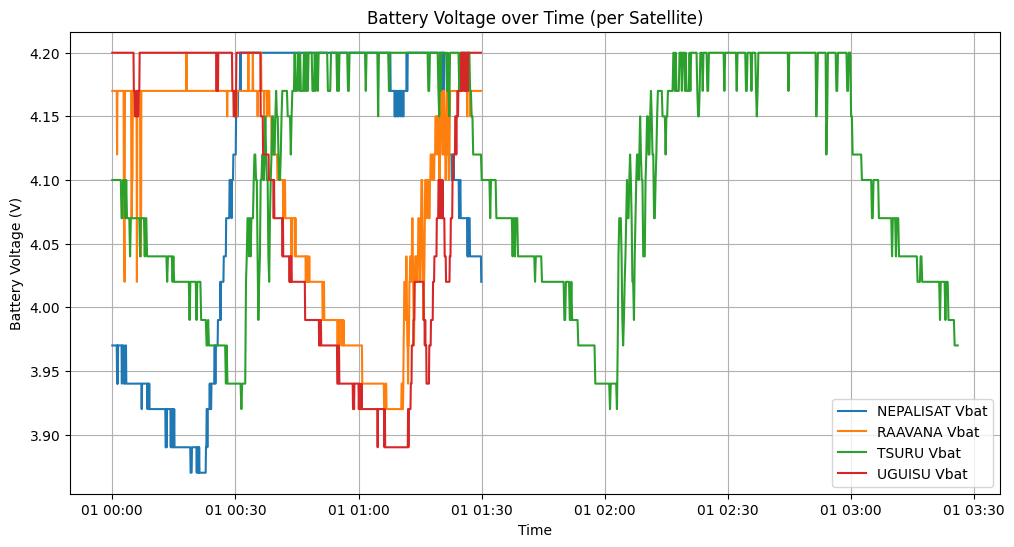

In [92]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for sat, df_sat in df_all.groupby("satellite"):
    plt.plot(df_sat["timestamp"], df_sat["vbat_(v)"], label=f"{sat} Vbat")

plt.title("Battery Voltage over Time (per Satellite)")
plt.xlabel("Time")
plt.ylabel("Battery Voltage (V)")
plt.legend()
plt.grid(True)
plt.show()

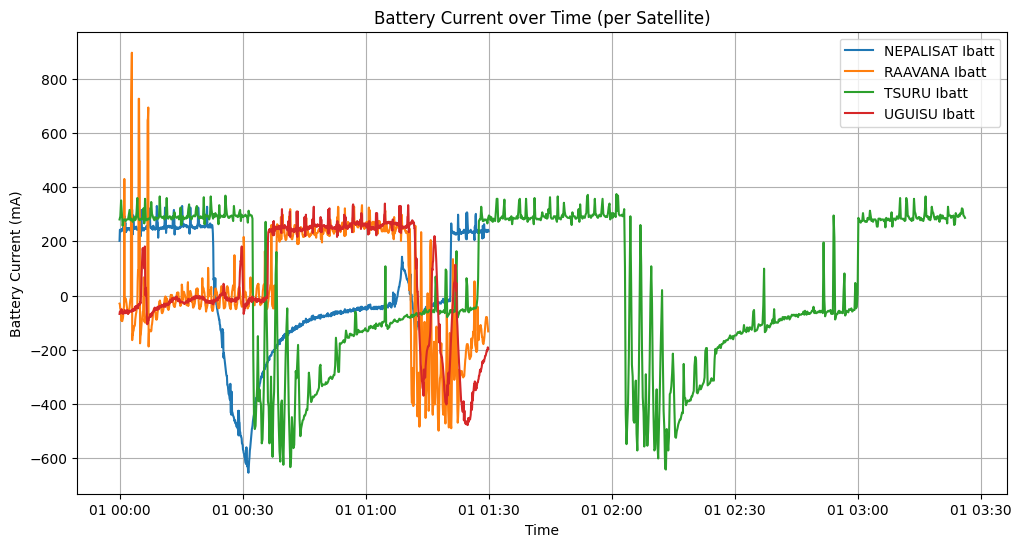

In [93]:
plt.figure(figsize=(12, 6))
for sat, df_sat in df_all.groupby("satellite"):
    plt.plot(df_sat["timestamp"], df_sat["ibatt(ma)"], label=f"{sat} Ibatt")

plt.title("Battery Current over Time (per Satellite)")
plt.xlabel("Time")
plt.ylabel("Battery Current (mA)")
plt.legend()
plt.grid(True)
plt.show()

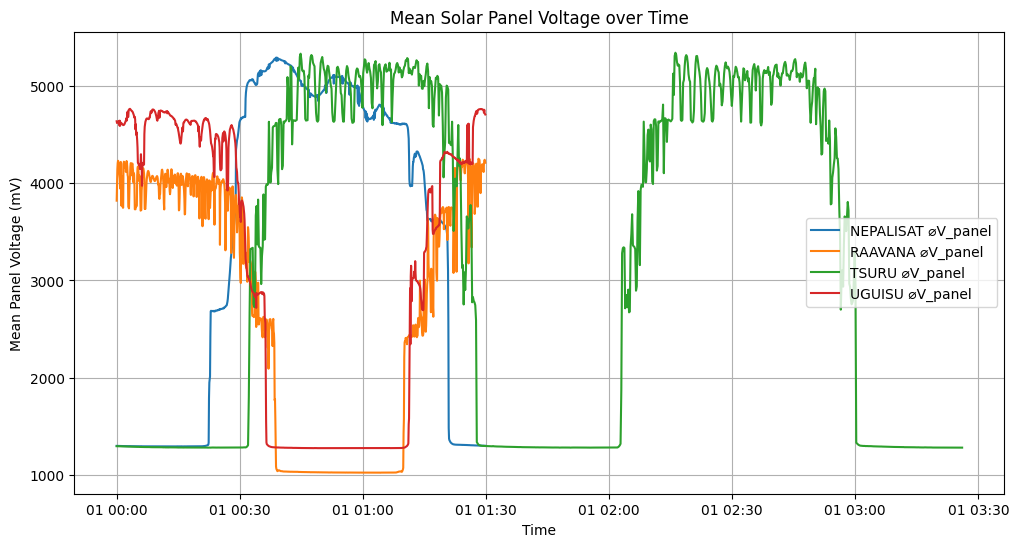

In [94]:
panel_voltage_cols = [c for c in df_all.columns if c.startswith("v") and "(mv)" in c and not c.startswith("vbat")]
df_all["solar_v_mean"] = df_all[panel_voltage_cols].mean(axis=1)

plt.figure(figsize=(12, 6))
for sat, df_sat in df_all.groupby("satellite"):
    plt.plot(df_sat["timestamp"], df_sat["solar_v_mean"], label=f"{sat} ⌀V_panel")

plt.title("Mean Solar Panel Voltage over Time")
plt.xlabel("Time")
plt.ylabel("Mean Panel Voltage (mV)")
plt.legend()
plt.grid(True)
plt.show()


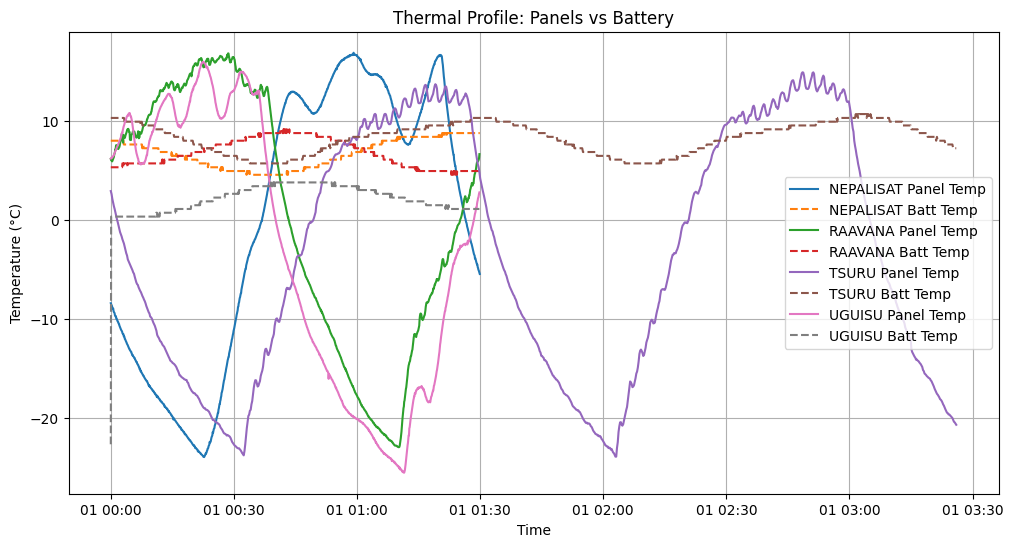

In [95]:
plt.figure(figsize=(12, 6))
for sat, df_sat in df_all.groupby("satellite"):
    tpanel_mean = df_sat[[c for c in df_sat.columns if "t" in c and "(c)" in c and "batt" not in c]].astype(float).mean(axis=1)
    plt.plot(df_sat["timestamp"], tpanel_mean, label=f"{sat} Panel Temp")
    plt.plot(df_sat["timestamp"], df_sat["tbatt_(c)"], "--", label=f"{sat} Batt Temp")

plt.title("Thermal Profile: Panels vs Battery")
plt.xlabel("Time")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.show()


<Axes: >

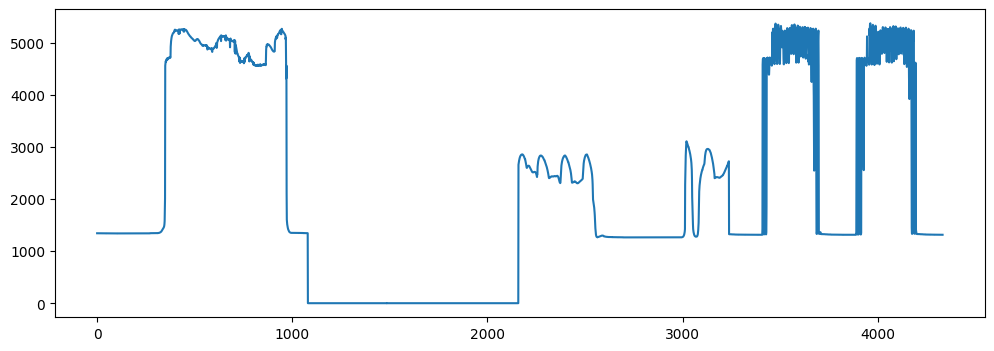

In [96]:
df_all["vpy_(mv)"].plot(figsize=(12,4))


## step 3 feature engineering

In [97]:
df_all.columns  

Index(['time_stamp', 'tpy_(c)', 'tpx_(c)', 'tmz_(c)', 'tmx_(c)', 'tpz_(c)',
       'vpy_(mv)', 'vpx_(mv)', 'vmz_(mv)', 'vmx_(mv)', 'vpz_(mv)', 'ipy_(ma)',
       'ipx_(ma)', 'imz_(ma)', 'imx_(ma)', 'ipz_(ma)', 'vbat_(v)', 'ibatt(ma)',
       'tbatt_(c)', 'timestamp', 'satellite', 'solar_v_mean'],
      dtype='object')

In [98]:
def engineer_features(df, frac_threshold=0.05, min_threshold=0.3):
    df = df.copy()

    # Keep labels intact
    if "timestamp" in df.columns:
        df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")

    # Ensure numeric for measurements only
    for c in df.columns:
        if c not in ("timestamp", "satellite"):
            df[c] = pd.to_numeric(df[c], errors="coerce")

    # --- Compute power per panel face ---
    panel_axes = ["py", "px", "pz", "mx", "mz"]
    power_cols = []
    for ax in panel_axes:
        v_col = f"v{ax}_(mv)"
        i_col = f"i{ax}_(ma)"
        p_col = f"p_{ax}_mw"
        if v_col in df.columns and i_col in df.columns:
            # mV * mA = mW; divide by 1e3 if you prefer Watts
            df[p_col] = df[v_col] * df[i_col] / 1e6  # → W
            power_cols.append(p_col)
        else:
            print(f"⚠️ Missing {v_col} or {i_col}, skipping {ax} face")

    # --- Total solar power ---
    df["p_solar_total"] = df[power_cols].sum(axis=1) if power_cols else np.nan

    # --- Battery power & net power ---
    # vbat_(v) * ibatt(ma) → mW; divide by 1e3 for W
    df["p_batt"] = df["vbat_(v)"] * df["ibatt(ma)"] / 1e3  # → W
    df["p_net"] = df["p_solar_total"] - df["p_batt"]

    # --- Adaptive eclipse threshold per satellite ---
    max_per_sat = df.groupby("satellite")["p_solar_total"].transform("max")
    threshold = np.maximum(frac_threshold * max_per_sat, min_threshold)
    df["eclipse_flag"] = (df["p_solar_total"] < threshold).astype(int)

    # --- Sort before derivatives ---
    if {"satellite", "timestamp"}.issubset(df.columns):
        df = df.sort_values(["satellite", "timestamp"])

    # --- Battery voltage derivative (per second) ---
    if "vbat_(v)" in df.columns and pd.api.types.is_datetime64_any_dtype(df["timestamp"]):
        dt_sec = df.groupby("satellite")["timestamp"].diff().dt.total_seconds()
        dv = df.groupby("satellite")["vbat_(v)"].diff()
        df["dvbat_dt"] = dv / dt_sec
    else:
        df["dvbat_dt"] = np.nan
    df["dvbat_dt"] = np.clip(df["dvbat_dt"], -0.01, 0.01)

    # --- Mean panel temperature (numeric-only) ---
    t_cols = [c for c in df.columns if c.startswith("t") and c.endswith("_(c)") and "batt" not in c]
    df["tpanel_mean"] = (
        df[t_cols].apply(pd.to_numeric, errors="coerce").mean(axis=1) if t_cols else np.nan
    )

    # --- Charge/discharge state ---
    df["charge_state"] = (df["ibatt(ma)"] < 0).astype(int) if "ibatt(ma)" in df.columns else np.nan

    return df

In [99]:
df_feat = engineer_features(df_all)
df_feat.head(3)[["timestamp","satellite","vbat_(v)","ibatt(ma)","tbatt_(c)","p_solar_total",
                 "eclipse_flag","p_net","dvbat_dt","tpanel_mean","charge_state"]]

,timestamp,satellite,vbat_(v),ibatt(ma),tbatt_(c),p_solar_total,eclipse_flag,p_net,dvbat_dt,tpanel_mean,charge_state
0,2020-01-01 00:00:00,NEPALISAT,3.97,201.84,7.96,0.024317,1,-0.776988,NaN,-8.442,0
1,2020-01-01 00:00:05,NEPALISAT,3.97,242.84,7.96,0.024317,1,-0.939758,0.0,-8.530,0
2,2020-01-01 00:00:10,NEPALISAT,3.97,242.84,7.96,0.024317,1,-0.939758,0.0,-8.662,0


In [100]:
def analyse_dataset(df):
    print("\n📈 --- GLOBAL STATISTICS ---")
    print(f"Total samples: {len(df):,}")
    print("Satellites:", df['satellite'].unique().tolist())

    print("\n🔋 Battery voltage & current range:")
    print(df.groupby("satellite")[["vbat_(v)", "ibatt(ma)"]].agg(["min","mean","max"]))

    print("\n☀️ Solar total power (W):")
    print(df.groupby("satellite")["p_solar_total"].agg(["min","mean","max"]))

    print("\n🌑 Eclipse flag ratio per satellite:")
    eclipse_ratio = df.groupby("satellite")["eclipse_flag"].mean()
    print((eclipse_ratio * 100).round(2).astype(str) + "% in eclipse")

    print("\n⚡ Power balance check (P_net):")
    print(df.groupby("satellite")["p_net"].describe()[["min","mean","max"]])

    print("\n🔧 dVbat/dt statistics (V/s):")
    print(df.groupby("satellite")["dvbat_dt"].describe()[["min","mean","max"]])

    print("\n🌡️ Panel temperature summary (°C):")
    print(df.groupby("satellite")["tpanel_mean"].describe()[["min","mean","max"]])

    # --- Visual check: optional if matplotlib available ---
    import matplotlib.pyplot as plt
    for sat, g in df.groupby("satellite"):
        fig, ax1 = plt.subplots(figsize=(8,4))
        ax1.set_title(f"{sat} – Solar Power vs Eclipse")
        ax1.plot(g["timestamp"], g["p_solar_total"], label="P_solar_total", color="orange")
        ax1.set_ylabel("Solar Power (W)")
        ax2 = ax1.twinx()
        ax2.plot(g["timestamp"], g["eclipse_flag"], label="Eclipse flag", color="blue", alpha=0.4)
        ax2.set_ylabel("Eclipse flag")
        fig.tight_layout()
        plt.show()



📈 --- GLOBAL STATISTICS ---
Total samples: 4,333
Satellites: ['NEPALISAT', 'RAAVANA', 'TSURU', 'UGUISU']

🔋 Battery voltage & current range:
          vbat_(v)                ibatt(ma)                   
               min      mean  max       min       mean     max
satellite                                                     
NEPALISAT     3.87  4.098898  4.2   -653.24   5.277546  330.69
RAAVANA       3.92  4.094662  4.2   -498.03  38.987285  895.87
TSURU         3.92  4.108603  4.2   -641.52  33.937553  374.62
UGUISU        3.89  4.084680  4.2   -477.54  52.755348  339.48

☀️ Solar total power (W):
                min      mean       max
satellite                              
NEPALISAT  0.018222  1.131618  4.183990
RAAVANA    0.035832  1.065625  3.772478
TSURU      0.030213  1.177432  4.302260
UGUISU     0.023755  0.982770  3.506251

🌑 Eclipse flag ratio per satellite:
satellite
NEPALISAT    35.65% in eclipse
RAAVANA      36.24% in eclipse
TSURU        45.94% in eclipse
UGUISU    

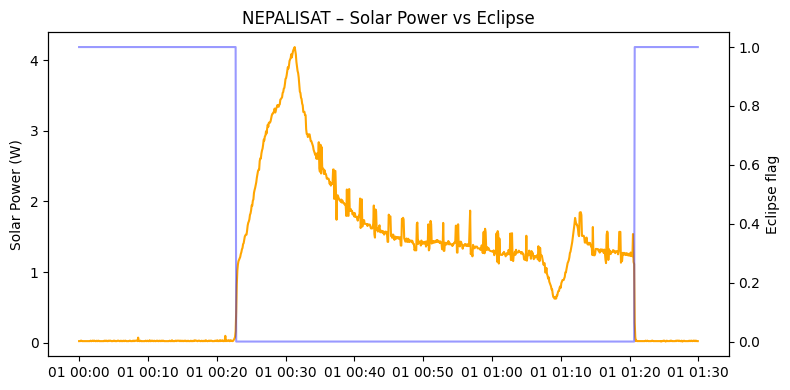

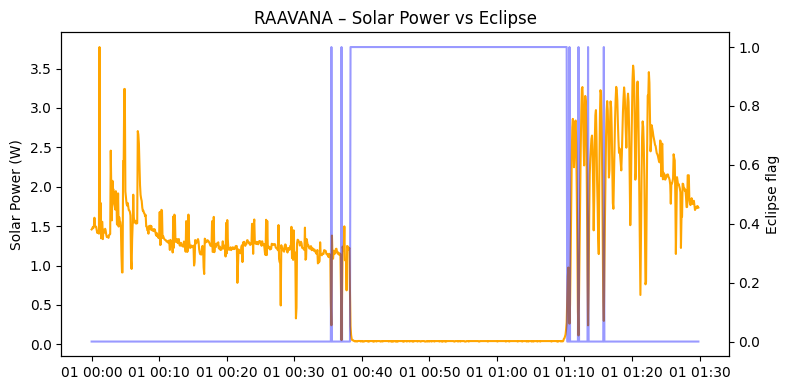

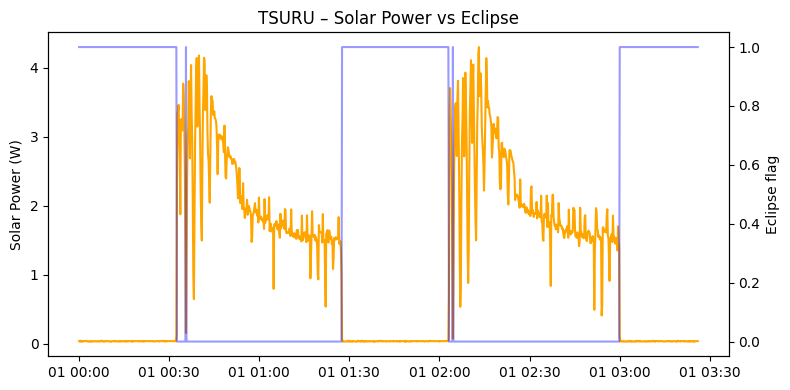

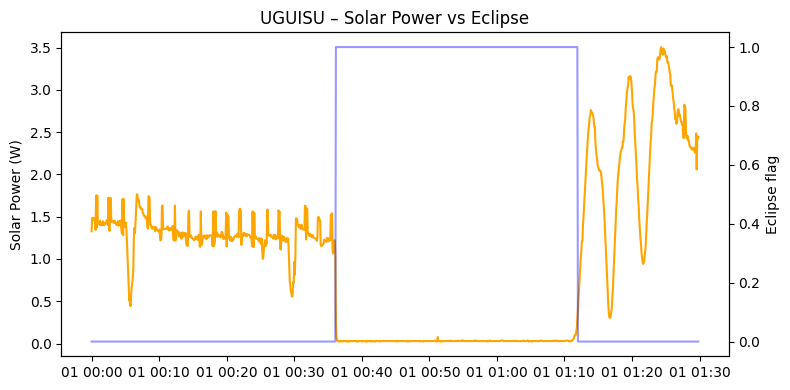

In [101]:
analyse_dataset(df_feat)


In [102]:
df_feat.describe()[["vbat_(v)", "ibatt(ma)", "tbatt_(c)", "p_solar_total",
                   "eclipse_flag", "p_net", "dvbat_dt", "tpanel_mean", "charge_state"]]

,vbat_(v),ibatt(ma),tbatt_(c),p_solar_total,eclipse_flag,p_net,dvbat_dt,tpanel_mean,charge_state
count,4333.000000,4333.000000,4333.000000,4333.000000,4333.000000,4333.000000,4329.000000,4333.000000,4333.000000
mean,4.096755,32.737519,5.945694,1.089696,0.394415,0.970505,-0.000004,-1.488711,0.533810
min,3.870000,-653.240000,-22.680000,0.018222,0.000000,-2.027878,-0.010000,-25.552000,0.000000
25%,4.020000,-85.140000,4.520000,0.036159,0.000000,-0.962158,0.000000,-14.366000,0.000000
50%,4.150000,-11.930000,6.050000,1.238655,0.000000,1.303410,0.000000,-0.318000,1.000000
75%,4.200000,251.630000,8.350000,1.632974,1.000000,1.967625,0.000000,11.492000,1.000000
max,4.200000,895.870000,10.650000,4.302260,1.000000,6.977398,0.010000,16.842000,1.000000
std,0.105573,227.523909,2.708212,1.023927,0.488781,1.934676,0.001677,13.362757,0.498913


In [103]:
# 2️⃣ Correlation overview
df_feat[["vbat_(v)","ibatt(ma)","p_solar_total","p_net","tpanel_mean","eclipse_flag"]].corr()


,vbat_(v),ibatt(ma),p_solar_total,p_net,tpanel_mean,eclipse_flag
vbat_(v),1.000000,-0.621525,0.615274,0.619478,0.900339,-0.782745
ibatt(ma),-0.621525,1.000000,-0.968281,-0.991123,-0.320144,0.822952
p_solar_total,0.615274,-0.968281,1.000000,0.992827,0.309809,-0.831087
p_net,0.619478,-0.991123,0.992827,1.000000,0.312370,-0.831223
tpanel_mean,0.900339,-0.320144,0.309809,0.312370,1.000000,-0.629362
eclipse_flag,-0.782745,0.822952,-0.831087,-0.831223,-0.629362,1.000000


## step 4 SoC reconstruction 

In [104]:
import numpy as np
import pandas as pd

def apply_payload_scenario(
    df_feat: pd.DataFrame,
    extra_load_ma_eclipse: float = 250.0,   # +250 mA pendant l’éclipse (↑ décharge)
    extra_load_ma_sun: float = 100.0,         
    keep_original: bool = True
) -> pd.DataFrame:
    """
    Simule un payload plus gourmand:
      - ajoute un courant de charge utile (mA) pendant l’éclipse (eclipse_flag=1)
      - optionnellement aussi en soleil (eclipse_flag=0)
    Convention: ibatt(ma) > 0 ⇒ décharge batterie; ibatt(ma) < 0 ⇒ charge batterie.
    """
    req = {"satellite", "timestamp", "vbat_(v)", "ibatt(ma)", "eclipse_flag", "p_solar_total"}
    missing = [c for c in req if c not in df_feat.columns]
    if missing:
        raise KeyError(f"Colonnes manquantes pour la simulation: {missing}")

    df = df_feat.copy()
    if keep_original and "ibatt_orig(ma)" not in df.columns:
        df["ibatt_orig(ma)"] = df["ibatt(ma)"]

    # Masques
    m_ecl = (df["eclipse_flag"] == 1)
    m_sun = (df["eclipse_flag"] == 0)

    # Ajout d’un courant de consommation (toujours POSITIF ⇒ ↑ décharge)
    df.loc[m_ecl, "ibatt(ma)"] = df.loc[m_ecl, "ibatt(ma)"] + extra_load_ma_eclipse
    if extra_load_ma_sun != 0:
        df.loc[m_sun, "ibatt(ma)"] = df.loc[m_sun, "ibatt(ma)"] + extra_load_ma_sun

    # Recalcul des grandeurs dépendantes
    # P_batt = Vbat * Ibatt/1000 (W) ; P_net = P_solar_total - P_batt
    df["p_batt"] = df["vbat_(v)"] * df["ibatt(ma)"] / 1e3
    df["p_net"] = df["p_solar_total"] - df["p_batt"]
    df["charge_state"] = (df["ibatt(ma)"] < 0).astype(int)

    return df


In [105]:
def estimate_soc0(df_sat, default_soc0=0.8):
    """
    Estimate or assign the initial SoC.
    Falls back to a default if voltage-based estimate is unreliable.
    """
    try:
        v_rest = df_sat["vbat_(v)"].median()
        if np.isfinite(v_rest):
            vmin, vmax = 3.8, 4.2    # narrower range to reduce bias
            soc0 = (v_rest - vmin) / (vmax - vmin)
            soc0 = float(np.clip(soc0, 0.2, 0.95))  # keep within a plausible band
        else:
            soc0 = default_soc0
    except Exception:
        soc0 = default_soc0
    return soc0

def estimate_soc0_fixed(df_sat, default_soc0=0.8):
    """
    use estimate_soc0 function
    """
    sc=estimate_soc0(df_sat, default_soc0=default_soc0)
    return float(np.clip(sc, 0.0, 1.0))

def coulomb_count_one_sat_discharge_positive(df_sat, capacity_ah=3.5, eta=1.0, soc0=0.8):
    """
    Coulomb counting avec convention:
      Ibatt > 0  ⇒ décharge  ⇒ SoC DIMINUE
      Ibatt < 0  ⇒ charge    ⇒ SoC AUGMENTE
    """
    g = df_sat.sort_values("timestamp").copy()
    I_A = g["ibatt(ma)"] / 1000.0
    dt = g["timestamp"].diff().dt.total_seconds().fillna(0)
    C = capacity_ah * 3600.0

    soc = np.empty(len(g), dtype=float)
    soc[0] = float(np.clip(soc0, 0.0, 1.0))
    for k in range(1, len(g)):
        I_eff = I_A.iloc[k-1] * eta
        # décharge (I>0) ⇒ SoC diminue
        soc[k] = soc[k-1] - (I_eff * dt.iloc[k]) / C

    return np.clip(soc, 0.0, 1.0)

def reconstruct_soc_discharge_positive(df, capacity_map=None, eta=1.0, soc0_default=0.8):
    df = df.copy()
    df["soc"] = np.nan
    for sat, g in df.groupby("satellite"):
        cap = (capacity_map or {}).get(sat, 3.5)
        soc0 = estimate_soc0_fixed(g, default_soc0=soc0_default)
        soc_trace = coulomb_count_one_sat_discharge_positive(
            g, capacity_ah=cap, eta=eta, soc0=soc0
        )
        df.loc[g.index, "soc"] = soc_trace
        print(f"🛰️ {sat}: SoC₀={soc0:.3f}, C={cap:.2f} Ah, samples={len(g)}")
    clip0 = (df["soc"] <= 0).mean()*100
    clip1 = (df["soc"] >= 1).mean()*100
    print(f"✅ SoC reconstructed. Clip 0%: {clip0:.3f}% | 100%: {clip1:.3f}%")
    return df


In [106]:
# 1) Point de départ: df_feat (tes features propres)
# 2) Simule une conso supplémentaire pendant l’éclipse (ex: +250 mA)
df_simu = apply_payload_scenario(df_feat, extra_load_ma_eclipse=250.0, extra_load_ma_sun=20.0)

# 3) Reconstruis la SoC avec la convention "Ibatt>0 = décharge"
df_soc = reconstruct_soc_discharge_positive(
    df_simu,
    capacity_map={s:2.0 for s in df_feat["satellite"].unique()},
    eta=0.9,            # pas d’atténuation
    soc0_default=0.8   # SoC de départ raisonnable
)

# 4) Petit résumé
print(df_soc.groupby("satellite")["soc"].describe()[["min","mean","max"]])


🛰️ NEPALISAT: SoC₀=0.950, C=2.00 Ah, samples=1080
🛰️ RAAVANA: SoC₀=0.875, C=2.00 Ah, samples=1079
🛰️ TSURU: SoC₀=0.800, C=2.00 Ah, samples=1095
🛰️ UGUISU: SoC₀=0.750, C=2.00 Ah, samples=1079
✅ SoC reconstructed. Clip 0%: 0.000% | 100%: 0.000%
                min      mean       max
satellite                              
NEPALISAT  0.862759  0.901906  0.950000
RAAVANA    0.749580  0.827440  0.875400
TSURU      0.553922  0.674110  0.800000
UGUISU     0.612400  0.697838  0.751417


In [107]:
for sat, g in df_soc.groupby("satellite"):
    Δsoc = g["soc"].iloc[-1] - g["soc"].iloc[0]
    print(f"🛰️ {sat}: SoC drift over run = {Δsoc:.4f}")


🛰️ NEPALISAT: SoC drift over run = -0.0721
🛰️ RAAVANA: SoC drift over run = -0.0961
🛰️ TSURU: SoC drift over run = -0.2461
🛰️ UGUISU: SoC drift over run = -0.1110


In [108]:
df_soc.groupby("satellite")["ibatt(ma)"].describe()[["min","mean","max"]]


,min,mean,max
satellite,,,
NEPALISAT,-633.24,107.268287,580.69
RAAVANA,-478.03,142.332975,915.87
TSURU,-621.52,159.590521,624.62
UGUISU,-457.54,164.414291,589.48


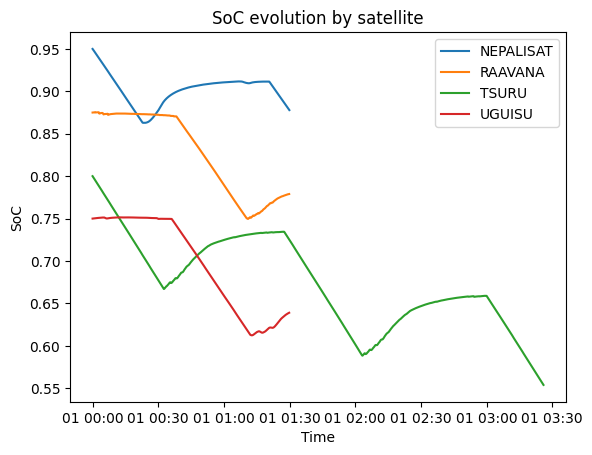

In [109]:
import matplotlib.pyplot as plt
for sat, g in df_soc.groupby("satellite"):
    plt.plot(g["timestamp"], g["soc"], label=sat)
plt.legend(); plt.ylabel("SoC"); plt.xlabel("Time")
plt.title("SoC evolution by satellite"); plt.show()


In [110]:
analyze_power_balance(df_soc)


🔍 --- EPS POWER DIAGNOSTIC ---

🛰️ NEPALISAT
Samples: 1080 | Mean Δt: 5.00s
Battery charging 42.3% of time, discharging 57.7% of time
Mean Ibatt sunlight=-111.2 mA, eclipse=+501.7 mA
Mean P_solar=1.132 W, mean P_batt=0.412 W
Net integrated charge over 1.50 h = +0.160 Ah
Corr(Psolar, Ibatt)=-0.972, Corr(Eclipse, Ibatt)=+0.917
🔋 Battery gained net charge → long sunlight / low load.

🛰️ RAAVANA
Samples: 1079 | Mean Δt: 5.00s
Battery charging 58.3% of time, discharging 41.7% of time
Mean Ibatt sunlight=-60.0 mA, eclipse=+498.3 mA
Mean P_solar=1.066 W, mean P_batt=0.564 W
Net integrated charge over 1.50 h = +0.213 Ah
Corr(Psolar, Ibatt)=-0.912, Corr(Eclipse, Ibatt)=+0.895
🔋 Battery gained net charge → long sunlight / low load.

🛰️ TSURU
Samples: 1095 | Mean Δt: 11.30s
Battery charging 48.9% of time, discharging 51.1% of time
Mean Ibatt sunlight=-166.5 mA, eclipse=+543.4 mA
Mean P_solar=1.177 W, mean P_batt=0.631 W
Net integrated charge over 3.43 h = +0.547 Ah
Corr(Psolar, Ibatt)=-0.986, Co

In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def validate_eps_dataset(df):
    """
    Validate logical consistency and visualize EPS telemetry & SoC behaviour.
    Expects columns:
      ['timestamp','satellite','vbat_(v)','ibatt(ma)','p_solar_total',
       'p_net','eclipse_flag','soc']
    """
    print("\n🧭 --- DATASET VALIDATION REPORT ---")

    # --- 1️⃣ Basic checks ---
    print(f"Total samples: {len(df):,}")
    print(f"Satellites: {df['satellite'].unique().tolist()}")
    print(f"Time coverage:")
    print(df.groupby("satellite")["timestamp"].agg(["min","max"]))

    # Check for NaNs
    nan_ratio = df.isna().mean().sort_values(ascending=False)
    print("\n🔍 Missing value ratio (top 10):")
    print((nan_ratio.head(10) * 100).round(2).astype(str) + "%")

    # --- 2️⃣ Sampling & time consistency ---
    print("\n⏱️ Sampling interval (median Δt) per satellite:")
    dt_median = df.groupby("satellite")["timestamp"].diff().dt.total_seconds().median()
    print(df.groupby("satellite")["timestamp"].diff().dt.total_seconds().describe())

    # --- 3️⃣ Check sign correlations ---
    print("\n⚡ Correlation check (should be strongly negative):")
    corr = df.groupby("satellite")[["p_solar_total","ibatt(ma)"]].corr().iloc[0::2,-1]
    print(corr)
    if (corr < -0.8).all():
        print("✅ Strong negative correlation between solar power and battery current.")
    else:
        print("⚠️ Some satellites show weak correlation → possible flag or data issue.")

    # --- 4️⃣ Physical ranges ---
    print("\n📈 Physical range checks:")
    ranges = df.groupby("satellite")[["vbat_(v)","ibatt(ma)","p_solar_total","soc"]].agg(["min","max"])
    print(ranges)
    if df["vbat_(v)"].between(3.7,4.25).mean() > 0.95:
        print("✅ Battery voltage within physical range (3.7–4.2V) for most samples.")
    else:
        print("⚠️ Voltage outside expected range detected.")

    # --- 5️⃣ SoC monotonic consistency ---
    print("\n🔋 SoC temporal behavior check:")
    for sat, g in df.groupby("satellite"):
        dsoc = g["soc"].diff()
        charge_up = (dsoc[g["ibatt(ma)"]<0] > 0).mean()
        discharge_down = (dsoc[g["ibatt(ma)"]>0] < 0).mean()
        print(f"🛰️ {sat}: SoC↑ during charge={charge_up:.2%}, SoC↓ during discharge={discharge_down:.2%}")

    # --- 6️⃣ Visual checks ---
    for sat, g in df.groupby("satellite"):
        fig, axs = plt.subplots(3, 1, figsize=(10,8), sharex=True)
        fig.suptitle(f"{sat} – EPS Behaviour", fontsize=14)

        axs[0].plot(g["timestamp"], g["vbat_(v)"], label="Vbat (V)", color="tab:blue")
        axs[0].set_ylabel("Vbat (V)")
        axs[0].legend(loc="upper left")

        axs[1].plot(g["timestamp"], g["ibatt(ma)"], label="Ibatt (mA)", color="tab:red")
        axs[1].plot(g["timestamp"], g["p_solar_total"]*200, label="P_solar*200", color="tab:orange", alpha=0.6)
        axs[1].set_ylabel("Current (mA)")
        axs[1].legend(loc="upper left")

        axs[2].plot(g["timestamp"], g["soc"], label="SoC", color="tab:green")
        axs[2].fill_between(g["timestamp"], 0, g["eclipse_flag"], color="black", alpha=0.1, label="Eclipse")
        axs[2].set_ylabel("State of Charge")
        axs[2].set_xlabel("Time")
        axs[2].legend(loc="upper left")

        plt.tight_layout()
        plt.show()

    # --- 7️⃣ Correlation heatmap ---
    corr_cols = ["vbat_(v)","ibatt(ma)","p_solar_total","p_net","tpanel_mean","soc"]
    corr_mat = df[corr_cols].corr()
    plt.figure(figsize=(7,5))
    sns.heatmap(corr_mat, annot=True, cmap="coolwarm", center=0)
    plt.title("Correlation heatmap of key EPS variables")
    plt.tight_layout()
    plt.show()

    print("\n✅ Validation complete. Examine plots for smooth SoC evolution and opposite trends between solar power & current.")



🧭 --- DATASET VALIDATION REPORT ---
Total samples: 4,333
Satellites: ['NEPALISAT', 'RAAVANA', 'TSURU', 'UGUISU']
Time coverage:
                 min                     max
satellite                                   
NEPALISAT 2020-01-01 2020-01-01 01:29:55.000
RAAVANA   2020-01-01 2020-01-01 01:29:50.000
TSURU     2020-01-01 2020-01-01 03:26:02.200
UGUISU    2020-01-01 2020-01-01 01:29:50.000

🔍 Missing value ratio (top 10):
dvbat_dt      0.09%
time_stamp     0.0%
tpx_(c)        0.0%
tpy_(c)        0.0%
tmz_(c)        0.0%
tmx_(c)        0.0%
vpy_(mv)       0.0%
tpz_(c)        0.0%
vmz_(mv)       0.0%
vmx_(mv)       0.0%
dtype: object

⏱️ Sampling interval (median Δt) per satellite:
count    4329.000000
mean        6.592100
std         2.738098
min         5.000000
25%         5.000000
50%         5.000000
75%        11.300000
max        11.300000
Name: timestamp, dtype: float64

⚡ Correlation check (should be strongly negative):
satellite               
NEPALISAT  p_solar_total   -

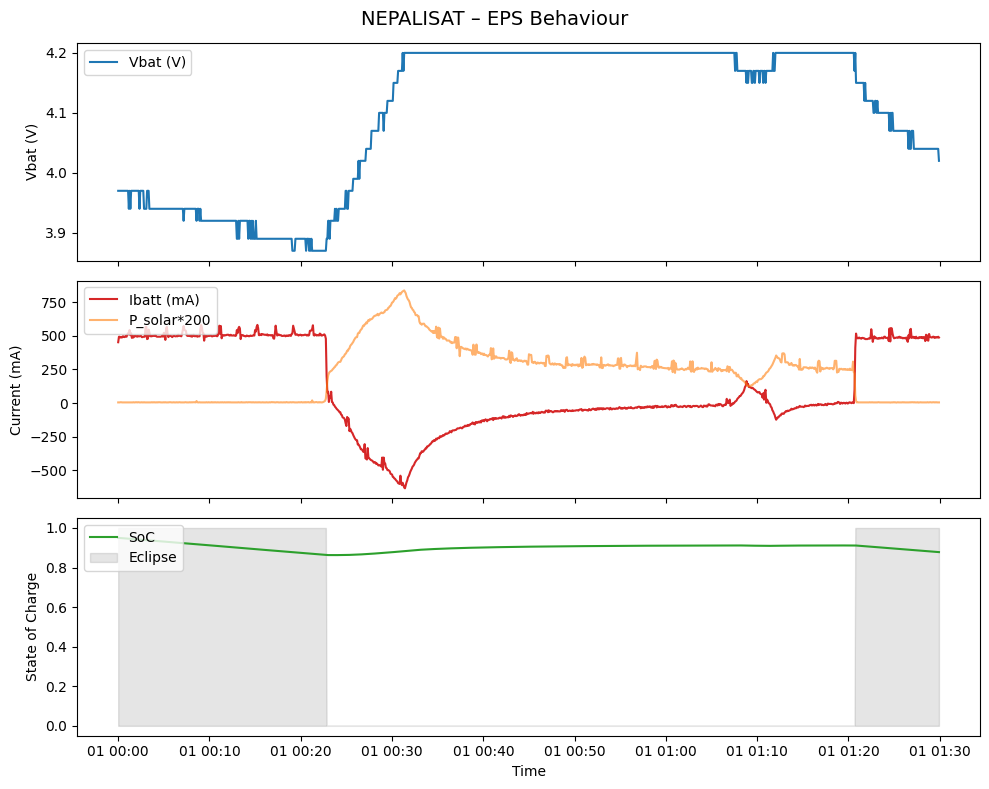

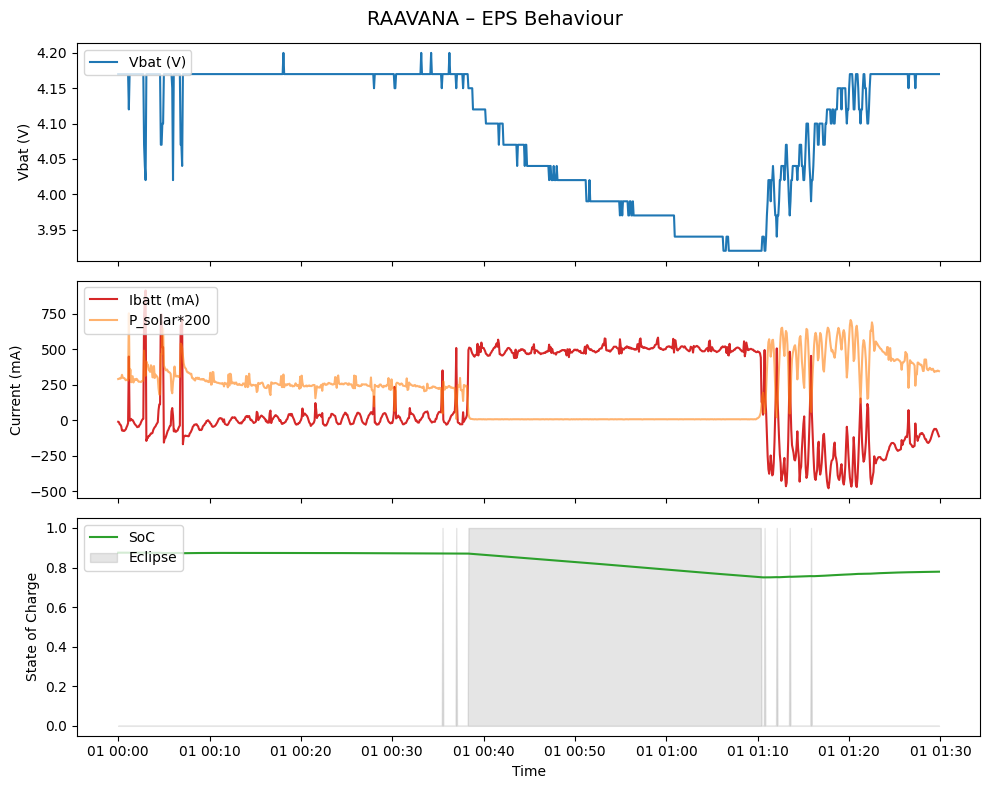

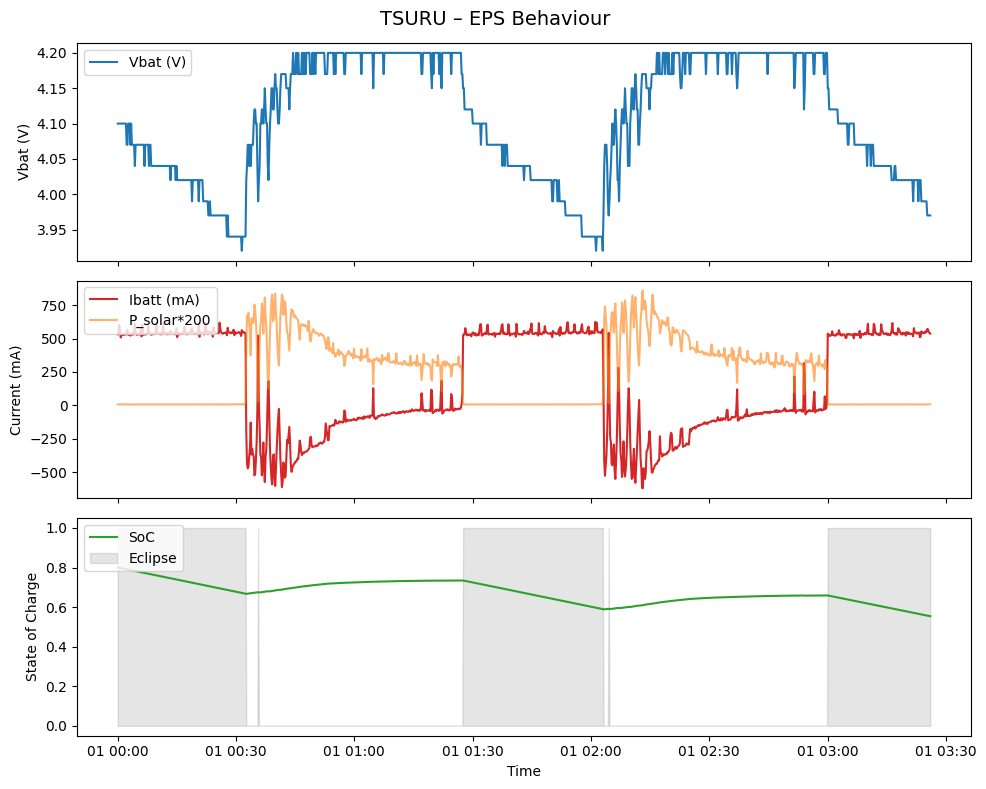

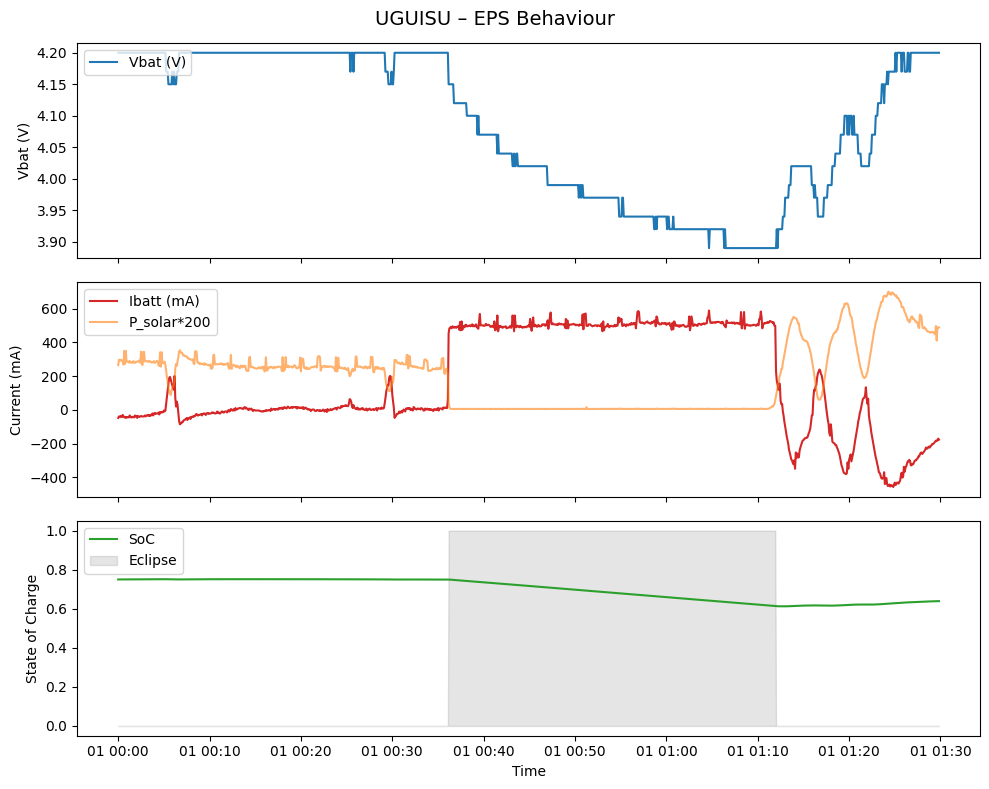

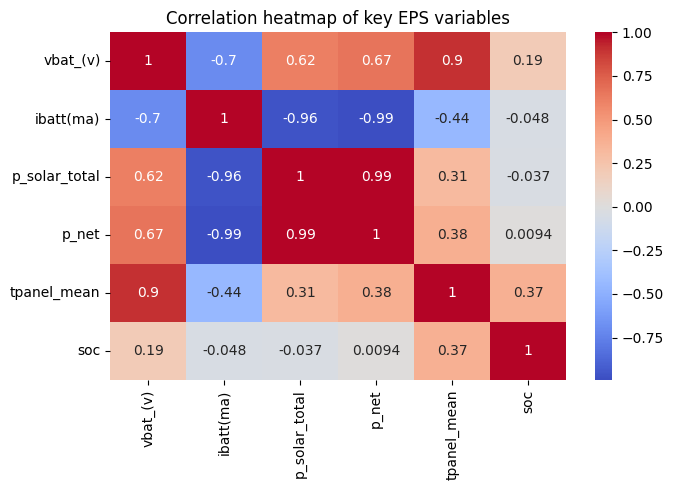


✅ Validation complete. Examine plots for smooth SoC evolution and opposite trends between solar power & current.


In [112]:
validate_eps_dataset(df_soc)

## step 5 SoC(t+15 min)

In [122]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 15 min = 900 s
FORECAST_HORIZON_S = 900


In [123]:
def make_future_target(df, horizon_s=900):
    df = df.sort_values(["satellite", "timestamp"]).copy()
    df["soc_target"] = np.nan
    for sat, g in df.groupby("satellite"):
        dt = g["timestamp"].diff().dt.total_seconds().fillna(0)
        # Convert horizon (s) to number of samples ≈ horizon / median Δt
        step = int(round(horizon_s / dt.median()))
        df.loc[g.index, "soc_target"] = g["soc"].shift(-step)
    # Drop last rows without valid target
    df = df.dropna(subset=["soc_target"]).reset_index(drop=True)
    return df

df_target = make_future_target(df_soc, horizon_s=FORECAST_HORIZON_S)
print(df_target[["timestamp", "satellite", "soc", "soc_target", "eclipse_flag"]].head())


            timestamp  satellite       soc  soc_target  eclipse_flag
0 2020-01-01 00:00:00  NEPALISAT  0.950000    0.893179             1
1 2020-01-01 00:00:05  NEPALISAT  0.949718    0.892840             1
2 2020-01-01 00:00:10  NEPALISAT  0.949410    0.892508             1
3 2020-01-01 00:00:15  NEPALISAT  0.949102    0.892154             1
4 2020-01-01 00:00:20  NEPALISAT  0.948797    0.891791             1



🔎 Verifying future target alignment (t → t+15 min)


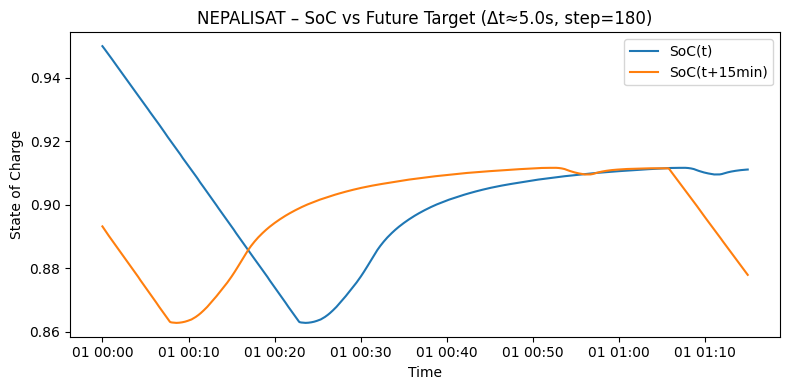

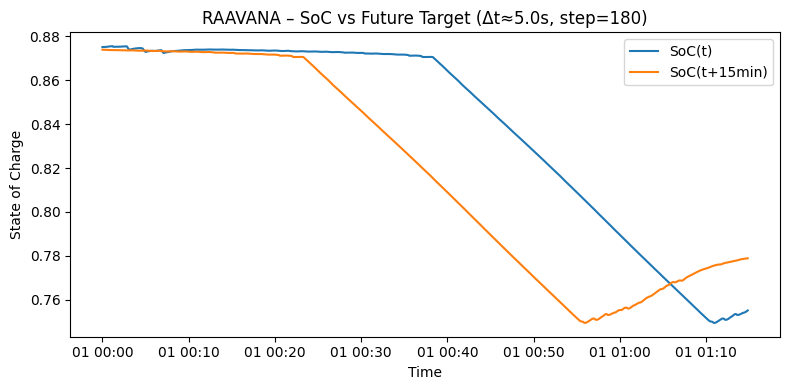

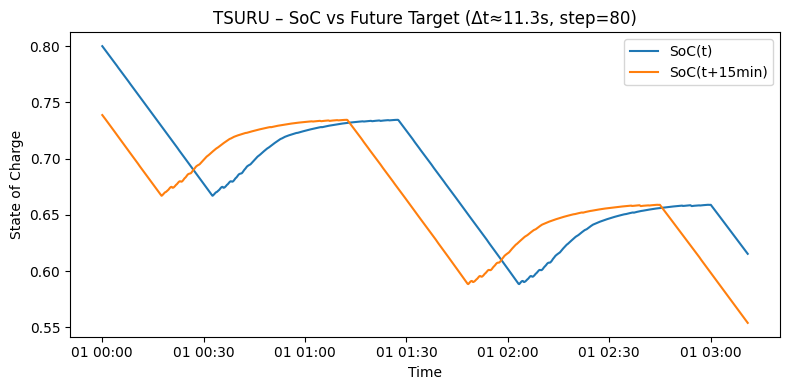

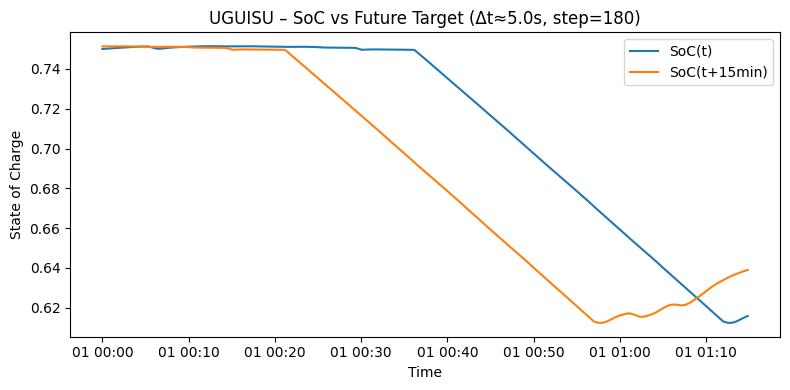

   satellite  dt_median(s)  step  mean_time_error(s)  max_time_error(s)  \
0  NEPALISAT           5.0   180                 0.0                0.0   
1    RAAVANA           5.0   180                 0.0                0.0   
2      TSURU          11.3    80                 4.0                4.0   
3     UGUISU           5.0   180                 0.0                0.0   

   corr(soc,soc_target)  
0                -0.231  
1                 0.829  
2                 0.718  
3                 0.871  

✅ Expect |mean_time_error| < 10 s and corr > 0.9 for smooth alignment.


In [124]:
import matplotlib.pyplot as plt

def verify_future_target_alignment(df_target, horizon_s=900):
    print("\n🔎 Verifying future target alignment (t → t+15 min)")
    results = []

    for sat, g in df_target.groupby("satellite"):
        g = g.sort_values("timestamp")
        dt_s = g["timestamp"].diff().dt.total_seconds().median()
        step = int(round(horizon_s / dt_s))

        # Check alignment error in seconds between expected and actual target timestamps
        t_future_expected = g["timestamp"] + pd.to_timedelta(horizon_s, unit="s")
        t_future_actual = g["timestamp"].shift(-step)
        delta = (t_future_actual - t_future_expected).dt.total_seconds().dropna()
        mean_error = delta.mean()
        max_error = delta.abs().max()

        # Quick sanity check: directionality of SoC change
        corr = g["soc"].corr(g["soc_target"])
        results.append((sat, dt_s, step, mean_error, max_error, corr))

        # Plot example
        plt.figure(figsize=(8,4))
        plt.plot(g["timestamp"], g["soc"], label="SoC(t)")
        plt.plot(g["timestamp"], g["soc_target"], label=f"SoC(t+{horizon_s/60:.0f}min)")
        plt.title(f"{sat} – SoC vs Future Target (Δt≈{dt_s:.1f}s, step={step})")
        plt.xlabel("Time")
        plt.ylabel("State of Charge")
        plt.legend()
        plt.tight_layout()
        plt.show()

    # Display summary
    res_df = pd.DataFrame(results, columns=["satellite","dt_median(s)","step","mean_time_error(s)","max_time_error(s)","corr(soc,soc_target)"])
    print(res_df.round(3))
    print("\n✅ Expect |mean_time_error| < 10 s and corr > 0.9 for smooth alignment.")

# Run verification
verify_future_target_alignment(df_target, horizon_s=900)


In [160]:
# Save final dataset with features and future target df_target
output_path = Path("eps_dataset_with_future_target.csv")
df_target.to_csv(output_path, index=False)


In [ ]:
import numpy as np
import pandas as pd

def make_sequences(df, seq_len=180, horizon_s=900):
    """
    Build input/output sequences for LSTM.
    seq_len: number of past samples (e.g. 180 for 15 min history)
    horizon_s: prediction horizon in seconds (e.g. 900 s = 15 min)
    """
    out_X, out_y, out_sat = [], [], []
    df = df.sort_values(["satellite", "timestamp"]).copy()

    for sat, g in df.groupby("satellite"):
        g = g.reset_index(drop=True)
        dt = g["timestamp"].diff().dt.total_seconds().median()
        step = int(round(horizon_s / dt))

        features = [
            "soc", "vbat_(v)", "ibatt(ma)", "p_solar_total",
            "p_net", "tpanel_mean", "eclipse_flag", "charge_state"
        ]
        g = g[features].dropna().reset_index(drop=True)

        for i in range(len(g) - seq_len - step):
            seq = g.iloc[i:i+seq_len].values
            target = g["soc"].iloc[i+seq_len+step-1]
            out_X.append(seq)
            out_y.append(target)
            out_sat.append(sat)

    X = np.stack(out_X)
    y = np.array(out_y)
    sat_ids = np.array(out_sat)
    return X, y, sat_ids


In [158]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

# Make sequences (15 min past to predict SoC+15min)
X, y, sat_ids = make_sequences(df_soc, seq_len=360, horizon_s=900)


# Train/test split (chronological)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_shape = X_train.shape
X_train_flat = X_train.reshape(-1, X_shape[-1])
X_test_flat = X_test.reshape(-1, X_shape[-1])

scaler.fit(X_train_flat)
X_train = scaler.transform(X_train_flat).reshape(X_shape)
X_test = scaler.transform(X_test_flat).reshape(X_test.shape)


# Normalize inputs
mean = X_train.mean(axis=(0,1))
std = X_train.std(axis=(0,1))
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

soc_mean, soc_std = y_train.mean(), y_train.std()
y_train_n = (y_train - soc_mean) / soc_std
y_test_n = (y_test - soc_mean) / soc_std





# Model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=X_train.shape[1:]),
    Dropout(0.2),
    LSTM(32),
    Dense(1, activation='linear')
])

model.compile(optimizer=Adam(1e-3), loss='mae')
model.summary()

# Train
model.fit(
    X_train, y_train_n,
    validation_split=0.1,
    epochs=100,
    batch_size=64,
    verbose=1,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(patience=5, factor=0.5, verbose=1),
        tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
    ]
)


y_pred_n = model.predict(X_test)
y_pred = y_pred_n * soc_std + soc_mean

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MAE={mae:.4f}, R²={r2:.3f}")


c:\Users\pc\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 360, 64)        │        18,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 360, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,137 (121.63 KB)

 Trainable params: 31,137 (121.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 194ms/step - loss: 0.4519 - val_loss: 0.2120 - learning_rate: 0.0010
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - loss: 0.1231 - val_loss: 0.2071 - learning_rate: 0.0010
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 193ms/step - loss: 0.0801 - val_loss: 0.2044 - learning_rate: 0.0010
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - loss: 0.0639 - val_loss: 0.2568 - learning_rate: 0.0010
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - loss: 0.0606 - val_loss: 0.2715 - learning_rate: 0.0010
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step - loss: 0.0497 - val_loss: 0.3073 - learning_rate: 0.0010
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 166ms/step - loss: 0.0491 - val_loss: 0.3122 - learning_rate: 0.0010
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 0.0449
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 190ms/step - loss: 0.0449 - val_loss: 0.3015 - le

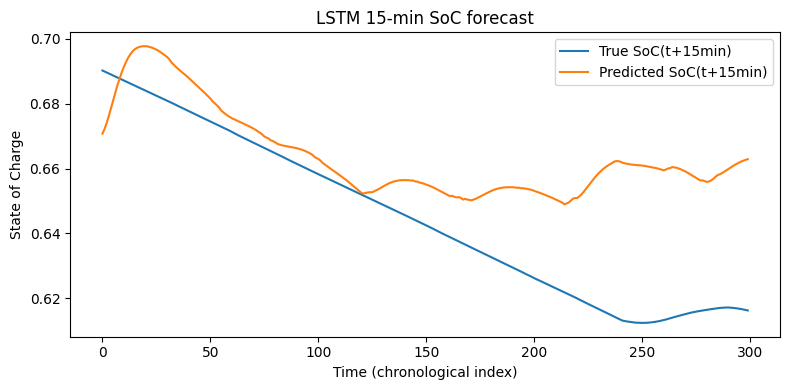

In [159]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(y_test[:300], label="True SoC(t+15min)")
plt.plot(y_pred[:300], label="Predicted SoC(t+15min)")
plt.xlabel("Time (chronological index)")
plt.ylabel("State of Charge")
plt.title("LSTM 15-min SoC forecast")
plt.legend()
plt.tight_layout()
plt.show()
